In [1]:
import pandas as pd
import numpy as np
import pickle
import copy
import operator
from tqdm import tqdm
from scipy.sparse import coo_matrix
from IPython.core.display import display, HTML
import implicit
display(HTML("<style>.container { width:90% !important; }</style>"))

In [2]:
df = pd.read_csv('./ratings.dat', sep='::', names=["uid", "iid", "rating", "timestamp"])
df.drop(columns=['timestamp', 'rating'], inplace=True)
df.head(2)

/home/zhuziwei/.local/lib/python3.6/site-packages/ipykernel_launcher.py:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  """Entry point for launching an IPython kernel.


,uid,iid
0,1,1193
1,1,661


In [3]:
item_df = pd.read_csv('./movies.dat', sep='::', names=["iid", "title", "genres"])
item_df.head(2)

/home/zhuziwei/.local/lib/python3.6/site-packages/ipykernel_launcher.py:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  """Entry point for launching an IPython kernel.


,iid,title,genres
0,1,Toy Story (1995),Animation|Children's|Comedy
1,2,Jumanji (1995),Adventure|Children's|Fantasy


In [4]:
# count the number for each genre and sort
item_genre_dict = dict()
for i in range(len(item_df)):
    genre_str = item_df.at[i, 'genres']
    genre_list = genre_str.split('|')
    item_genre_dict[item_df.at[i, 'iid']] = genre_list

genre_item_count = dict()
for l in item_genre_dict:
    for g in item_genre_dict[l]:
        if not g in genre_item_count:
            genre_item_count[g] = 1
        else:
            genre_item_count[g] += 1

genre_count_sorted = sorted(genre_item_count.items(), key=operator.itemgetter(1), reverse=True)
genre_count_sorted

[('Drama', 1603),
 ('Comedy', 1200),
 ('Action', 503),
 ('Thriller', 492),
 ('Romance', 471),
 ('Horror', 343),
 ('Adventure', 283),
 ('Sci-Fi', 276),
 ("Children's", 251),
 ('Crime', 211),
 ('War', 143),
 ('Documentary', 127),
 ('Musical', 114),
 ('Mystery', 106),
 ('Animation', 105),
 ('Fantasy', 68),
 ('Western', 68),
 ('Film-Noir', 44)]

In [5]:
# calculate feedback/item_count for each genre
genre_rating_count = dict()
itemIds = df['iid'].values
for i in range(len(itemIds)):
    itemId = itemIds[i]
    genres = item_genre_dict[itemId]
    for g in genres:
        if not g in genre_rating_count:
            genre_rating_count[g] = 1.
        else:
            genre_rating_count[g] += 1.
for g in genre_item_count:
    genre_rating_count[g] /= genre_item_count[g] * 1.
genre_count_sorted = sorted(genre_rating_count.items(), key=operator.itemgetter(1), reverse=True)
genre_count_sorted

[('Sci-Fi', 569.9057971014493),
 ('Fantasy', 533.8382352941177),
 ('Action', 511.8429423459244),
 ('War', 479.2097902097902),
 ('Adventure', 473.3321554770318),
 ('Film-Noir', 415.02272727272725),
 ('Animation', 412.3142857142857),
 ('Thriller', 385.5284552845528),
 ('Mystery', 379.0377358490566),
 ('Crime', 376.97156398104266),
 ('Musical', 364.32456140350877),
 ('Romance', 313.2123142250531),
 ('Western', 304.1617647058824),
 ('Comedy', 297.15),
 ("Children's", 287.59362549800795),
 ('Horror', 222.6997084548105),
 ('Drama', 221.16593886462883),
 ('Documentary', 62.28346456692913)]

In [6]:
genres_used = set(list(genre_rating_count.keys())) - {'(no genres listed)'}

In [7]:
# filter items by genres
delete_list = []
for i in range(len(item_df)):
    genre_str = item_df.at[i, 'genres']
    genre_list = genre_str.split('|')
    genre_overlap = genre_list
    if genre_str == '(no genres listed)':
        delete_list.append(i)
item_df.drop(delete_list, inplace=True)
keep_item_g = item_df['iid'].unique()
item_df.reset_index(drop=True, inplace=True)

In [8]:
# remove record for movies which do not have genres
df = df[df['iid'].isin(keep_item_g)]
df.reset_index(drop=True, inplace=True)

In [9]:
item_set = set(df['iid'].unique())
user_set = set(df['uid'].unique())
print('item num = ' + str(len(item_set)))
print('user num = ' + str(len(user_set)))

item num = 3706
user num = 6040


In [10]:
len(item_df)

3883

In [11]:
rdf = copy.copy(df)

In [13]:
keep_uid = np.random.choice(rdf['uid'].unique(), 1000, replace=False)

In [14]:
rdf = rdf[rdf['uid'].isin(keep_uid)]
rdf.reset_index(drop=True, inplace=True)

In [21]:
item_list = rdf['iid'].unique()
user_list = rdf['uid'].unique()
print('movie num = ' + str(len(item_list)))
print('user num = ' + str(len(user_list)))
print('sparsity: ' + str(len(rdf) * 1.0 / (len(user_list) * len(item_list))))

movie num = 3406
user num = 1000
sparsity: 0.04742160892542572


In [22]:
#remove movies from item_df
item_df = item_df[item_df['iid'].isin(item_list)]
item_df.reset_index(drop=True, inplace=True)

In [23]:
# get the user and item str id->int id dict
i = 0
user_old2new_id_dict = dict()
for u in user_list:
    if not u in user_old2new_id_dict:
        user_old2new_id_dict[u] = i
        i += 1
j = 0
item_old2new_id_dict = dict()
for i in item_list:
    if not i in item_old2new_id_dict:
        item_old2new_id_dict[i] = j
        j += 1

In [24]:
# convert the str id of items in item_df to int id
for i in range(len(item_df)):
    item_df.at[i, 'iid'] = item_old2new_id_dict[item_df.at[i, 'iid']]

In [25]:
# get rdf with int id for user and item
userIds = rdf['uid'].values
itemIds = rdf['iid'].values
userIdsNew = copy.copy(userIds)
itemIdsNew = copy.copy(itemIds)
for i in range(len(userIds)):
    userIdsNew[i] = user_old2new_id_dict[userIds[i]]
    itemIdsNew[i] = item_old2new_id_dict[itemIds[i]]
rdf['uid'] = userIdsNew
rdf['iid'] = itemIdsNew
item_list = rdf['iid'].unique()
user_list = rdf['uid'].unique()

In [26]:
import sys
sys.path.insert(0,'..')
import MF_CE
import utility
import tensorflow as tf

item_list = rdf['iid'].unique()
user_list = rdf['uid'].unique()
num_user = len(user_list)
num_item = len(item_list)

bs = int((len(rdf) * 6) / 100)

with tf.Session() as sess:
    mf = MF_CE.MF_CE(sess=sess, train_df=rdf, num_user=num_user, num_item=num_item, bs=bs, epoch=20)
    R = mf.run()

/home/zhuziwei/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/zhuziwei/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/zhuziwei/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/zhuziwei/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.


******************** MF_CE ********************





Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
********************* MF_CE Initialization Done *********************


 16%|█▋        | 15/91 [00:00<00:00, 144.92it/s]

negative Sampling time : 44 ms


 33%|███▎      | 30/91 [00:00<00:00, 292.82it/s]

Training // Epoch 1 //  Total cost = 62.59642 negative Sampling time : 44 ms negative samples : 875335
negative Sampling time : 46 ms


 34%|███▍      | 31/91 [00:00<00:00, 302.50it/s]

Training // Epoch 2 //  Total cost = 46.88905 negative Sampling time : 46 ms negative samples : 875482
negative Sampling time : 48 ms


 32%|███▏      | 29/91 [00:00<00:00, 288.98it/s]

Training // Epoch 3 //  Total cost = 33.82241 negative Sampling time : 48 ms negative samples : 875012
negative Sampling time : 52 ms


 34%|███▍      | 31/91 [00:00<00:00, 309.71it/s]

Training // Epoch 4 //  Total cost = 32.32905 negative Sampling time : 52 ms negative samples : 875294
negative Sampling time : 47 ms


 35%|███▌      | 32/91 [00:00<00:00, 317.55it/s]

Training // Epoch 5 //  Total cost = 31.58264 negative Sampling time : 47 ms negative samples : 875176
negative Sampling time : 48 ms


 33%|███▎      | 30/91 [00:00<00:00, 292.67it/s]

Training // Epoch 6 //  Total cost = 30.73810 negative Sampling time : 48 ms negative samples : 875330
negative Sampling time : 58 ms


 32%|███▏      | 29/91 [00:00<00:00, 284.01it/s]

Training // Epoch 7 //  Total cost = 29.82649 negative Sampling time : 58 ms negative samples : 875702
negative Sampling time : 47 ms


 33%|███▎      | 30/91 [00:00<00:00, 294.71it/s]

Training // Epoch 8 //  Total cost = 28.96999 negative Sampling time : 47 ms negative samples : 875162
negative Sampling time : 48 ms


 35%|███▌      | 32/91 [00:00<00:00, 313.93it/s]

Training // Epoch 9 //  Total cost = 28.22944 negative Sampling time : 48 ms negative samples : 875513
negative Sampling time : 56 ms


 35%|███▌      | 32/91 [00:00<00:00, 310.48it/s]

Training // Epoch 10 //  Total cost = 27.55815 negative Sampling time : 56 ms negative samples : 875055
negative Sampling time : 47 ms


 33%|███▎      | 30/91 [00:00<00:00, 296.31it/s]

Training // Epoch 11 //  Total cost = 26.94974 negative Sampling time : 47 ms negative samples : 875667
negative Sampling time : 47 ms


 35%|███▌      | 32/91 [00:00<00:00, 310.07it/s]

Training // Epoch 12 //  Total cost = 26.34808 negative Sampling time : 47 ms negative samples : 875099
negative Sampling time : 55 ms


 35%|███▌      | 32/91 [00:00<00:00, 316.14it/s]

Training // Epoch 13 //  Total cost = 25.77243 negative Sampling time : 55 ms negative samples : 875478
negative Sampling time : 47 ms


 34%|███▍      | 31/91 [00:00<00:00, 307.64it/s]

Training // Epoch 14 //  Total cost = 25.18745 negative Sampling time : 47 ms negative samples : 875108
negative Sampling time : 46 ms


 36%|███▋      | 33/91 [00:00<00:00, 321.63it/s]

Training // Epoch 15 //  Total cost = 24.60292 negative Sampling time : 46 ms negative samples : 875633
negative Sampling time : 48 ms


 36%|███▋      | 33/91 [00:00<00:00, 321.01it/s]

Training // Epoch 16 //  Total cost = 24.02544 negative Sampling time : 48 ms negative samples : 875131
negative Sampling time : 46 ms


 33%|███▎      | 30/91 [00:00<00:00, 295.38it/s]

Training // Epoch 17 //  Total cost = 23.53790 negative Sampling time : 46 ms negative samples : 875409
negative Sampling time : 51 ms


 36%|███▋      | 33/91 [00:00<00:00, 319.06it/s]

Training // Epoch 18 //  Total cost = 22.89766 negative Sampling time : 51 ms negative samples : 875352
negative Sampling time : 48 ms


 34%|███▍      | 31/91 [00:00<00:00, 300.25it/s]

Training // Epoch 19 //  Total cost = 22.35877 negative Sampling time : 48 ms negative samples : 875226
negative Sampling time : 46 ms


100%|██████████| 91/91 [00:00<00:00, 304.51it/s]


Training // Epoch 20 //  Total cost = 21.77761 negative Sampling time : 46 ms negative samples : 874902


In [27]:
num_user = len(user_list)
num_item = len(item_list)
truth = np.zeros((num_user, num_item))
for u in tqdm(range(num_user)):
    for i in range(num_item):
        r = max(R[u, i] - 0.15, 0.01)
        tmp = np.random.random()
        if tmp <= r:
            truth[u, i] = 1.

np.sum(truth) * 1.0 / num_user / num_item

100%|██████████| 1000/1000 [00:10<00:00, 92.76it/s]


0.06572783323546683

In [28]:
audience_size = np.sum(truth, axis=0)
AS_sorted = np.sort(audience_size)
num_item = len(AS_sorted)
np.sum(((np.arange(num_item) + 1.) * 2 - num_item - 1) * AS_sorted) / (num_item * np.sum(AS_sorted))

0.6394292941540157

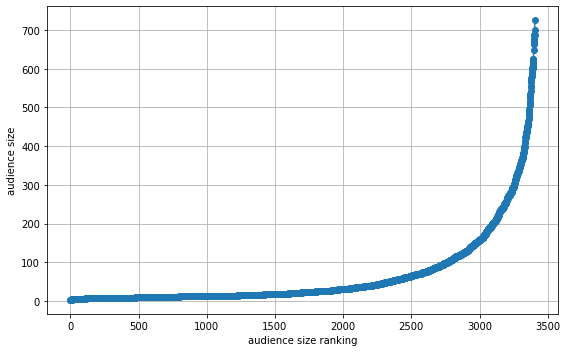

In [29]:
import matplotlib.pyplot as plt

audience_size = np.sum(truth, axis=0)

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8, 5))
ax.plot(range(len(audience_size)), np.sort(audience_size), marker='.', linewidth=1.5, markersize=12)
ax.set_ylabel('audience size')
ax.set_xlabel('audience size ranking')
ax.grid(True)
fig.patch.set_facecolor('white')
plt.tight_layout()
plt.show()

In [30]:
user_list, item_list = np.where(truth > 0)
truth_df = pd.DataFrame({'uid': user_list, 'iid': item_list})

In [31]:
# count the number for each genre and sort
item_genre_dict = dict()
for i in range(len(item_df)):
    genre_str = item_df.at[i, 'genres']
    genre_list = genre_str.split('|')
    genre_overlap = set(genre_list).intersection(genres_used)
    item_genre_dict[item_df.at[i, 'iid']] = list(genre_overlap)

genre_item_count = dict()
for l in item_genre_dict:
    for g in item_genre_dict[l]:
        if not g in genre_item_count:
            genre_item_count[g] = 1
        else:
            genre_item_count[g] += 1

genre_count_sorted = sorted(genre_item_count.items(), key=operator.itemgetter(1), reverse=True)
genre_count_sorted

[('Drama', 1336),
 ('Comedy', 1097),
 ('Action', 479),
 ('Thriller', 462),
 ('Romance', 436),
 ('Horror', 313),
 ('Adventure', 271),
 ('Sci-Fi', 265),
 ("Children's", 247),
 ('Crime', 191),
 ('War', 139),
 ('Musical', 108),
 ('Animation', 105),
 ('Mystery', 102),
 ('Documentary', 86),
 ('Fantasy', 67),
 ('Western', 62),
 ('Film-Noir', 41)]

In [32]:
# calculate feedback/item_count for each genre
genre_rating_count = dict()
itemIds = truth_df['iid'].values
for i in range(len(itemIds)):
    itemId = itemIds[i]
    genres = item_genre_dict[itemId]
    for g in genres:
        if not g in genre_rating_count:
            genre_rating_count[g] = 1
        else:
            genre_rating_count[g] += 1
for g in genre_item_count:
    genre_rating_count[g] /= genre_item_count[g] * 1.
genre_count_sorted = sorted(genre_rating_count.items(), key=operator.itemgetter(1), reverse=True)
genre_count_sorted

[('Sci-Fi', 140.8377358490566),
 ('Action', 121.8893528183716),
 ('Fantasy', 120.7910447761194),
 ('War', 114.19424460431655),
 ('Film-Noir', 111.70731707317073),
 ('Adventure', 110.49077490774907),
 ('Animation', 101.88571428571429),
 ('Crime', 96.75392670157068),
 ('Thriller', 96.57142857142857),
 ('Mystery', 88.6078431372549),
 ('Musical', 85.16666666666667),
 ('Romance', 75.36238532110092),
 ('Western', 73.56451612903226),
 ('Comedy', 70.06836827711942),
 ("Children's", 65.85425101214575),
 ('Drama', 60.6190119760479),
 ('Horror', 54.150159744408946),
 ('Documentary', 21.61627906976744)]

In [33]:
np.save('./truth.npy', truth)

In [34]:
item_df.reset_index(drop=True, inplace=True)
item_df.to_csv('./item_df.csv', index=False)

In [35]:
with open('./item_genre_dict.pkl', 'wb') as f:
    pickle.dump(item_genre_dict, f)

In [36]:
# generate list of items users like in train, warm_vali, warm_test sets for each user

num_item = len(item_list)
num_user = len(user_list)

user_truth_like = [[] for _ in range(num_user)]

for u in tqdm(user_list):
    truth_u = truth[u, :]
    truth_u_like = (np.where(truth_u > 0)[0]).astype(int)    
    user_truth_like[u] = truth_u_like
    
np.save('./user_truth_like.npy', np.array(user_truth_like))

100%|██████████| 223869/223869 [00:01<00:00, 153444.60it/s]
/home/zhuziwei/.local/lib/python3.6/site-packages/ipykernel_launcher.py:13: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  del sys.path[0]


In [37]:
audience_size = np.sum(truth, axis=0)

AS_sorted = np.sort(audience_size)
num_item = len(AS_sorted)
np.sum(((np.arange(num_item) + 1.) * 2 - num_item - 1) * AS_sorted) / (num_item * np.sum(AS_sorted))

0.6394292941540157

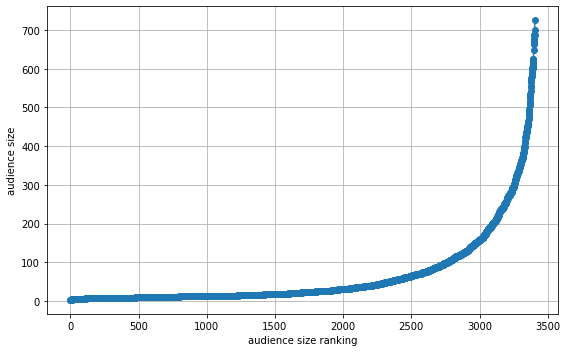

In [38]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8, 5))
ax.plot(range(len(audience_size)), np.sort(audience_size), marker='.', linewidth=1.5, markersize=12)
ax.set_ylabel('audience size')
ax.set_xlabel('audience size ranking')
ax.grid(True)
fig.patch.set_facecolor('white')
plt.tight_layout()
plt.show()

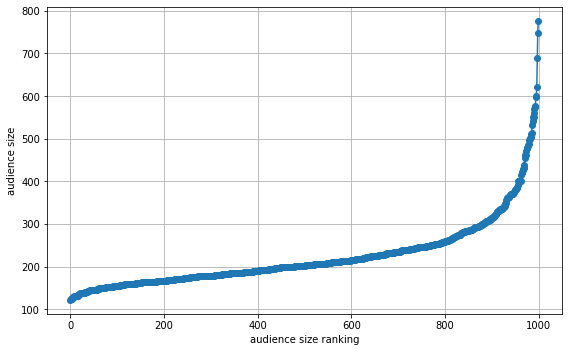

In [39]:
a = np.sum(truth, axis=1)

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8, 5))
ax.plot(range(len(a)), np.sort(a), marker='.', linewidth=1.5, markersize=12)
ax.set_ylabel('audience size')
ax.set_xlabel('audience size ranking')
ax.grid(True)
fig.patch.set_facecolor('white')
plt.tight_layout()
plt.show()